### Prepare Workspace

In [37]:
# Import system libraries
import os
import sys

# Import data cleaning libraries
import pandas as pd
import numpy as np
import calendar
from datetime import datetime

# Import machine learning libraries
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, GridSearchCV
import shap

# Import data visualisation libraries
import matplotlib.pyplot as plt 

# Import warning libraries
import warnings
warnings.filterwarnings("ignore")

# Set working directory
os.chdir('/Users/jessicarapson/Documents/GitHub/crop-yield-estimate/')
sys.path.insert(0, '/Users/jessicarapson/Documents/GitHub/crop-yield-estimate/pipeline')

# Import preprocessing libraries
from preprocessing import cleaning
from preprocessing import feature_engineering
from preprocessing import scaling
from preprocessing import feature_selection
from preprocessing import dim_reduction

# Preprocess data
train_path = "data/Train.csv"
test_path = "data/Test.csv"
df = cleaning.clean_data(train_path, test_path)
df = feature_engineering.get_features(df)
df = scaling.scale_features(df)
df = feature_selection.select_features(df)
df = dim_reduction.reduce_dim(df)

# Split data into training and test sets
df_train = df[df['Yield'].isna() == False]
df_test = df[df['Yield'].isna() == True]

### Build Yield Generic Yield Per Acre Model

Root Mean Squared Error: 132.80147838539122


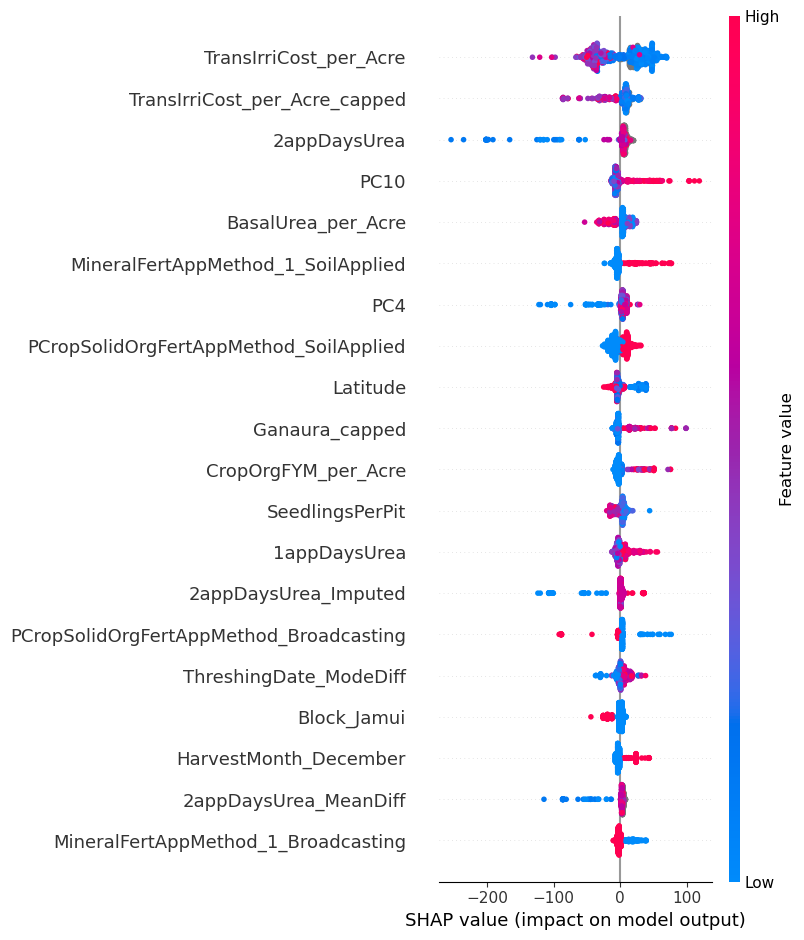

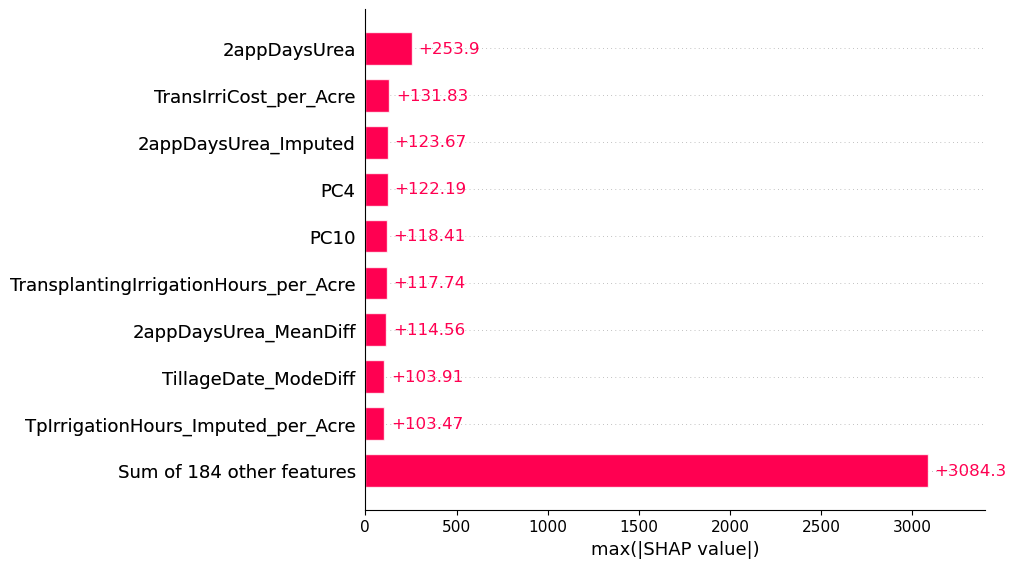

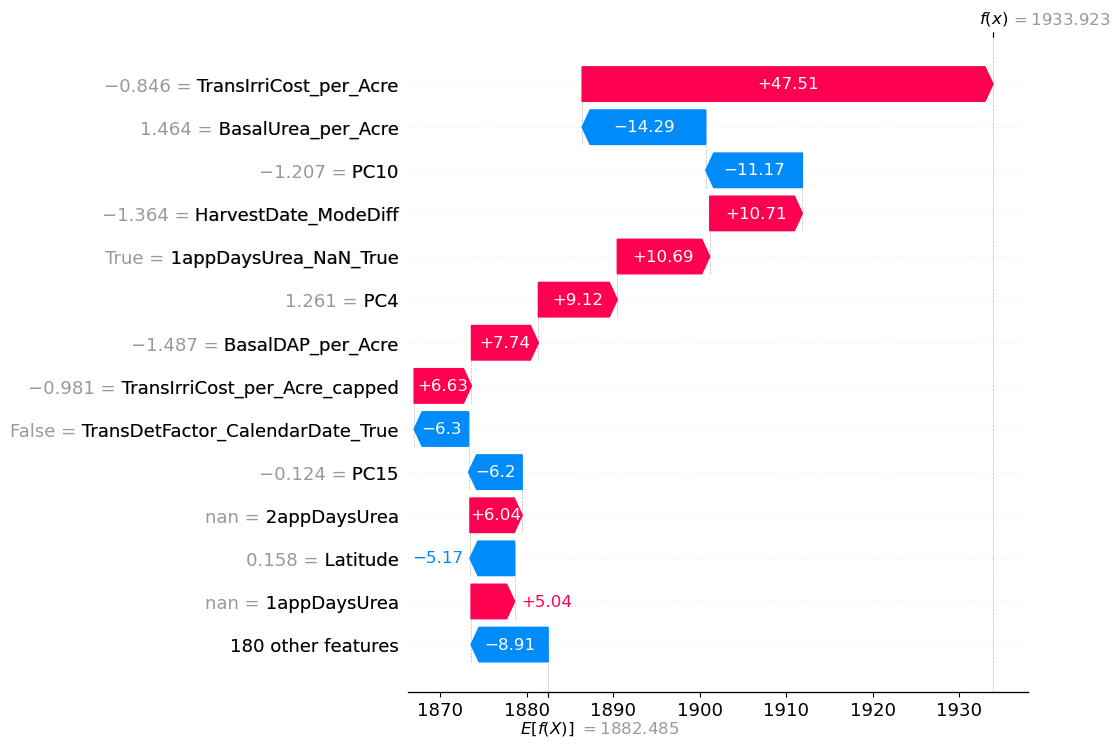

In [38]:
# Split data
outcome_cols = ["Yield","Yield_per_Acre","New_Yield","New_Yield_per_Acre"]
X, y = df_train.drop(outcome_cols, axis=1), df_train["New_Yield_per_Acre"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate an XGBoost regressor model
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3,
                          learning_rate = 0.1, max_depth = 5, alpha = 10,
                          n_estimators = 10)

# Train the XGBoost model
xg_reg.fit(X_train, y_train)

# Predict on the test set
y_pred = xg_reg.predict(X_test)

# Evaluate the model using RMSE (Root Mean Squared Error)
indices = list(y_test.index)
rmse = mean_squared_error(df_train.loc[indices]["New_Yield"],
                          y_pred * df_train.loc[indices]["Acre"], squared=False)
print("Root Mean Squared Error:", rmse)

# # Define the number of folds for cross-validation
# num_folds = 20

# # Split data into two folds
# fold_size = len(X) // num_folds
# for i in range(num_folds):
#     # Define the training and testing indices for this fold
#     test_indices = list(range(i * fold_size, (i + 1) * fold_size))
#     train_indices = [idx for idx in range(len(X)) if idx not in test_indices]

#     # Split the data into training and testing sets for this fold
#     X_train, X_test = X.iloc[train_indices], X.iloc[test_indices]
#     y_train, y_test = y.iloc[train_indices], y.iloc[test_indices]
    
# # Train your model on the training set
# xg_reg.fit(X_train, y_train)

# # Predict on the test set
# y_pred = xg_reg.predict(X_test)

# # Calculate and print the evaluation metric (e.g., RMSE)
# rmse = mean_squared_error(y_test, y_pred, squared=False)
# print(f"Fold {i+1} RMSE: {rmse}")

# Create a TreeExplainer object with the XGBoost model
explainer = shap.TreeExplainer(xg_reg)

# Calculate Shapley values for a specific sample (replace index with your desired sample index)
sample_index = 21
shap_values = explainer.shap_values(X_test)

# Summary plot of Shapleys values
shap.summary_plot(shap_values, X_test)
shap.plots.bar(explainer(X_test).abs.max(0))

shap_values = explainer(X)
shap.plots.waterfall(shap_values[sample_index], max_display=14)

### Make Predictions

In [39]:
# Retrain model on entire training data
xg_reg.fit(X, y)
print("---Training complete---")

---Training complete---


In [40]:
# Make predictions
test_predictors = df_test.drop(outcome_cols, axis=1)
test_pred = xg_reg.predict(test_predictors) * df_test["Acre"]

# Add predictions to sample submission file
df_test_pred = pd.read_csv("data/SampleSubmission.csv")
df_test_pred['Yield'] = test_pred
df_test_pred['Yield'] = np.where(df_test_pred['ID'] == 'ID_PMSOXFT4FYDW',
                                 df_test_pred['Yield'] * 10, df_test_pred['Yield'])

# Export submission
df_test_pred.to_csv('submission/Submission.csv', index=False)

print("---Predictions made---")

---Predictions made---


### Test Ideas

In [36]:
from sklearn.decomposition import PCA

# Identify predictors with no missing data
outcome_cols = ["Yield","Yield_per_Acre","New_Yield","New_Yield_per_Acre"]
missing = ['SeedlingsPerPit','TransplantingIrrigationHours','TransIrriCost',
           'StandingWater','1appDaysUrea','2appDaysUrea','TransplantingIrrigationHours_per_Acre',
           'TransIrriCost_per_Acre','TransIrriCost_per_Acre_capped','Days_bw_Nurs_SowTransp',
           'Days_bw_Nurs_Harv','Days_bw_Nurs_Till','NursingDate_ModeDiff',
           'Days_bw_Nurs_SowTransp_ModeDiff','Days_bw_Nurs_Till_ModeDiff',
           'Days_bw_Nurs_Harv_ModeDiff','2appDaysUrea_MeanDiff']
X = df.drop(outcome_cols + missing, axis=1)

# Initialize PCA with the number of components you want to retain
n_components = 21  # Set the number of components here
pca = PCA(n_components=n_components)

# Fit and transform the data
pca.fit(X)
X_pca = pca.transform(X)

# Get the explained variance ratio for each component
explained_variance_ratio = pca.explained_variance_ratio_
print("Explained variance ratio for each component:")
for i, evr in enumerate(explained_variance_ratio):
    print(f"Component {i + 1}: {evr:.4f}")
    
# Create column names for the new principal components
pc_columns = [f"PC{i+1}" for i in range(n_components)]

# Create a DataFrame for the principal components
df_pca = pd.DataFrame(data=X_pca, columns=pc_columns, index=X.index)

# Concatenate the principal components DataFrame with your original DataFrame
df_with_pca = pd.concat([df, df_pca], axis=1)

Explained variance ratio for each component:
Component 1: 0.1526
Component 2: 0.0940
Component 3: 0.0878
Component 4: 0.0698
Component 5: 0.0550
Component 6: 0.0527
Component 7: 0.0427
Component 8: 0.0374
Component 9: 0.0364
Component 10: 0.0333
Component 11: 0.0309
Component 12: 0.0292
Component 13: 0.0263
Component 14: 0.0239
Component 15: 0.0231
Component 16: 0.0190
Component 17: 0.0151
Component 18: 0.0146
Component 19: 0.0143
Component 20: 0.0111
Component 21: 0.0103


In [37]:
df_with_pca

,CultLand,CropCultLand,CropTillageDepth,SeedlingsPerPit,TransplantingIrrigationHours,TransIrriCost,StandingWater,Ganaura,CropOrgFYM,NoFertilizerAppln,...,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21
0,0.560165,0.560362,0.571429,0.047619,-0.096048,-0.443788,0.052632,-0.146433,-0.101615,0.333333,...,0.227472,0.040717,-1.084196,-0.568744,1.979527,0.277831,-1.677517,-0.254752,-1.880947,-0.789334
1,-0.092617,0.039792,0.571429,0.047619,-0.096048,-0.623574,0.105263,-0.146433,-0.101615,0.333333,...,-0.697493,-0.474804,1.357682,-0.403183,0.236286,-0.907281,-0.725056,0.558452,0.070941,-0.217828
2,-0.642329,-0.555145,0.714286,0.047619,-0.132006,-0.731445,0.052632,-0.133224,-0.096429,0.333333,...,2.965606,0.356923,1.638519,2.097562,-0.005423,-0.386432,-1.035810,0.929231,1.768466,-0.295805
3,-0.470544,-0.369227,0.714286,0.047619,NaN,NaN,NaN,-0.133224,-0.101615,0.333333,...,1.115121,-0.109881,0.566362,0.104642,-0.876037,-1.742195,-0.246427,0.544443,-2.726952,-0.258700
4,1.075520,1.304034,0.428571,0.047619,0.047782,-0.204073,0.052632,-0.146433,-0.101615,0.333333,...,-0.937251,0.478398,-0.075497,-0.816728,1.171633,-0.557029,-1.197834,0.432551,-1.231172,-0.530798
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1285,-0.298759,-0.332044,0.428571,0.000000,-0.167963,-0.443788,0.052632,-0.146433,-0.086055,0.666667,...,0.352801,1.442826,0.420616,-1.223238,0.187395,-0.090990,0.580409,-0.593668,0.231158,0.013201
1286,-0.126974,-0.406411,0.571429,0.047619,-0.203921,-0.204073,0.052632,-0.146433,-0.075682,0.000000,...,0.247817,-0.811520,0.882175,1.398031,-3.052511,-0.327113,1.882861,-1.631541,-0.316959,-0.684227
1287,-0.642329,-0.815430,0.714286,0.000000,-0.203921,-0.443788,0.052632,-0.146433,-0.023817,0.666667,...,-0.264400,-0.302477,-0.004984,0.107673,0.335818,0.616080,0.554073,-1.041359,0.400578,0.349317
1288,-0.642329,-0.555145,0.428571,0.142857,-0.203921,0.275356,0.105263,-0.146433,-0.101615,0.666667,...,-0.072126,-0.722545,-1.088831,-0.048480,0.529029,-0.116010,-0.509153,-0.254978,0.140158,0.759402


In [9]:
# Calculate mean of each column in the shap_values matrix
column_means = np.mean(shap_values, axis=0)

# Attach mean values to column names
column_means_with_names = {column: mean for column, mean in zip(X.columns, column_means)}

# Display column names with their mean values
for column, mean in column_means_with_names.items():
    print(f"{column}: {mean}")

CultLand: -0.11916788667440414
CropCultLand: 0.48876845836639404
CropTillageDepth: 1.2070658206939697
SeedlingsPerPit: 0.5156427025794983
TransplantingIrrigationHours: -0.03484385088086128
TransIrriCost: -0.010399268940091133
StandingWater: -1.2623933553695679
Ganaura: -0.09061281383037567
CropOrgFYM: 0.17311035096645355
NoFertilizerAppln: -0.13729339838027954
BasalDAP: 0.0
BasalUrea: 0.0756390318274498
1tdUrea: 0.2713451087474823
1appDaysUrea: 0.9972175359725952
2tdUrea: 0.00658424710854888
2appDaysUrea: -8.39331340789795
Harv_hand_rent: -0.13967600464820862
Residue_length: 1.6539134979248047
Residue_perc: 0.0
Acre: 0.3346126973628998
Yield: 0.06189992278814316
Nb_of_NaN: 0.0
TpIrrigationHours_Imputed: 0.5193368792533875
SeedlingsPerPit_Imputed: -0.5271309018135071
2appDaysUrea_Imputed: 0.0
Ganaura_capped: 0.4493175446987152
New_Yield: -0.12741544842720032
TransplantingIrrigationHours_per_Acre: -0.7494902610778809
TpIrrigationHours_Imputed_per_Acre: -0.49434947967529297
TransIrriCost_

In [30]:
df = cleaning.clean_data(train_path, test_path)
df = feature_engineering.get_features(df)

(array([  4.,   5.,   4.,   0.,   8.,  14.,   0.,   5.,   4.,   0.,   3.,
          6.,   0.,  10.,   1.,   0.,   7.,   8.,   0.,  31.,  66.,   0.,
         42.,  47.,   0.,  59., 164.,   0., 217., 176.,   0., 211., 266.,
          0., 280., 293.,   0., 297., 270.,   0., 240., 256.,   0., 257.,
        180.,   0., 161., 154.,   0., 167., 140.,   0., 122., 120.,   0.,
        116., 101.,   0.,  81.,  50.,   0.,  36.,  30.,   0.,  47.,  43.,
          0.,  35.,  30.,   0.,  25.,  16.,   0.,  19.,  14.,   0.,  11.,
         21.,   0.,  18.,   6.,   0.,   9.,  12.,   0.,   5.,   1.,   0.,
          5.,   1.,   0.,   4.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          3.]),
 array([-3.21027773, -3.13292697, -3.0555762 , -2.97822543, -2.90087466,
        -2.82352389, -2.74617313, -2.66882236, -2.59147159, -2.51412082,
        -2.43677005, -2.35941928, -2.28206852, -2.20471775, -2.12736698,
        -2.05001621, -1.97266544, -1.89531467, -1.81796391, -1.74061314,
        -1.66326237, -1.58

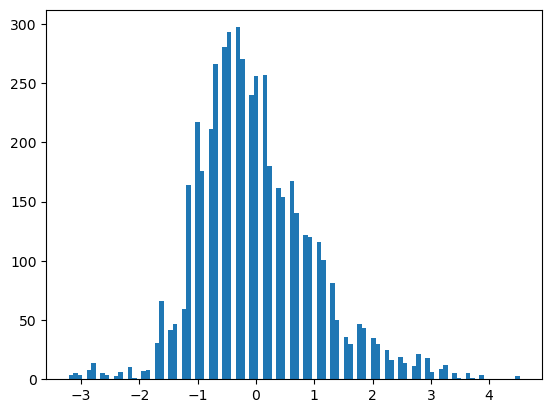

In [26]:
plt.hist(df['Days_bw_Nurs_SowTransp'], bins=100)

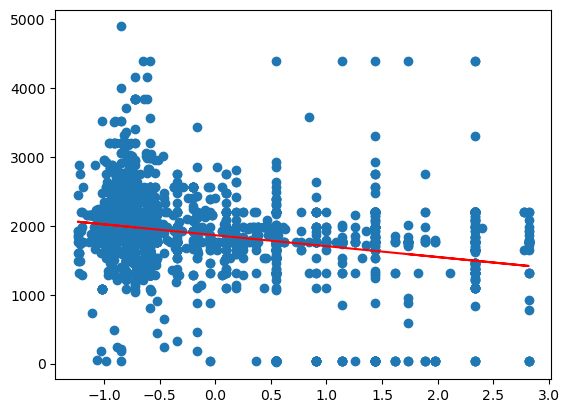

In [35]:
var = 'TransIrriCost_per_Acre_capped'

data = df_train[df_train[var].isna() == False]
slope, intercept = np.polyfit(data[var], data['New_Yield_per_Acre'], 1)

# Plot the line of best fit
plt.plot(data[var], slope * data[var] + intercept, color='red') 
plt.scatter(data[var], data['New_Yield_per_Acre'])

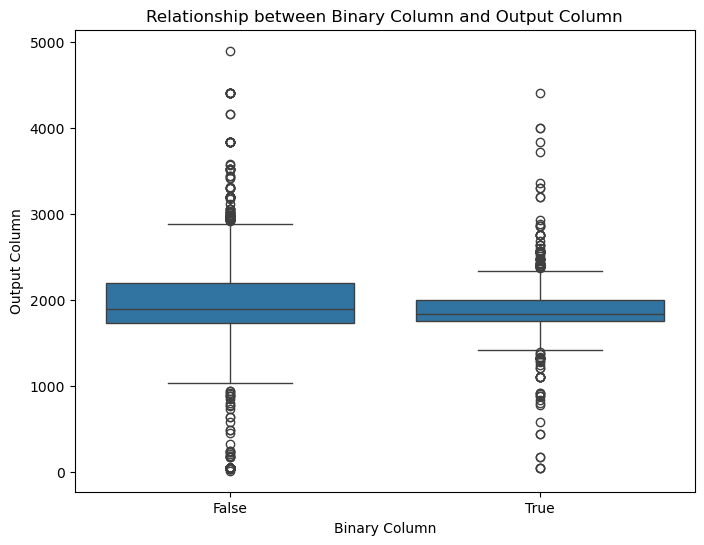

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a boxplot to visualize the relationship
plt.figure(figsize=(8, 6))
sns.boxplot(x='1appDaysUrea_NaN', y='New_Yield_per_Acre', data=df)
plt.xlabel('Binary Column')
plt.ylabel('Output Column')
plt.title('Relationship between Binary Column and Output Column')
plt.show()

In [25]:
cdf = df[['CropTillageDepth','CropEstMethod_LineSowingAfterTillage','CropEstMethod_Manual_PuddledLine',
          'CropEstMethod_Manual_PuddledRandom','SeedlingsPerPit_Imputed','TpIrrigationHours_Imputed',
          'TransplantingIrrigationSource_Boring','TransplantingIrrigationSource_Canal',
          'TransplantingIrrigationSource_Pond','TransplantingIrrigationSource_Rainfed',
          'LandPrepMethod_TractorPlough_True','LandPrepMethod_FourWheelTracRotavator_True',
          'LandPrepMethod_WetTillagePuddling_True','LandPrepMethod_BullockPlough_True',
          'CropbasalFerts_Urea_True','CropbasalFerts_DAP_True','CropbasalFerts_NPK_True','CropbasalFerts_NPKS_True',
          'CropbasalFerts_SSP_True','CropbasalFerts_Other_True','CropbasalFerts_None_True',
          'FirstTopDressFert_Urea_True','FirstTopDressFert_DAP_True','FirstTopDressFert_NPK_True',
          'FirstTopDressFert_None_True','OrgFertilizers_Ganaura_True','OrgFertilizers_FYM_True',
          'OrgFertilizers_VermiCompost_True','OrgFertilizers_Ghanajeevamrit_True','OrgFertilizers_None_True',
          'Ganaura_per_Acre','CropOrgFYM_per_Acre','PCropSolidOrgFertAppMethod_Broadcasting',
          'PCropSolidOrgFertAppMethod_RootApplication','PCropSolidOrgFertAppMethod_SoilApplied',
          'NoFertilizerAppln','MineralFertAppMethod_2_Broadcasting','MineralFertAppMethod_2_RootApplication',
          'MineralFertAppMethod_2_SoilApplied','Harv_method_machine','Threshing_method_machine']]

In [26]:
from sklearn.cluster import SpectralClustering
for k in range(2, 6):    
    spectral = SpectralClustering(n_clusters=k, assign_labels='discretize', random_state=0, n_init=200).fit(cdf)
    joblib.dump(spectral, 'spectral_clustering_model_k=' + str(k) + '.pkl')

KeyboardInterrupt: 